In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.python.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras import backend as K
import cv2

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Taking the dataset only for Ship and Airplane

In [4]:
y_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index_1,index_2 = y_classes.index("airplane"), y_classes.index("ship")

X_train_airplane = X_train[(y_train == index_1).ravel()][:]
X_test_airplane = X_test[(y_test == index_1).ravel()][:]
X_train_ship = X_train[(y_train == index_2).ravel()][:]
X_test_ship = X_test[(y_test == index_2).ravel()][:]


Few examples for the Ship and Airplane Dataset

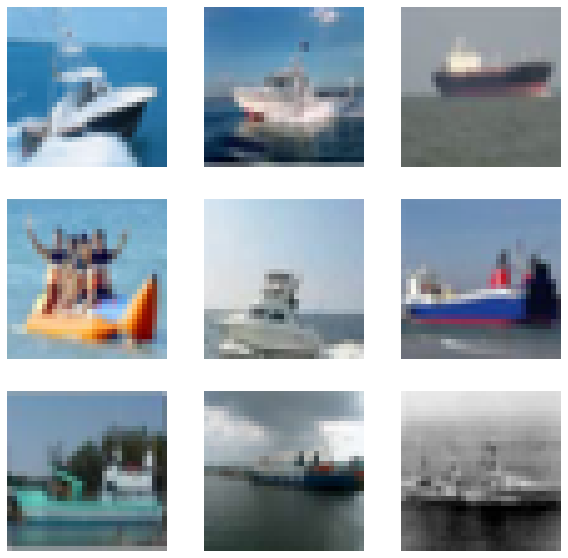

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_ship[i])
  plt.axis("off")

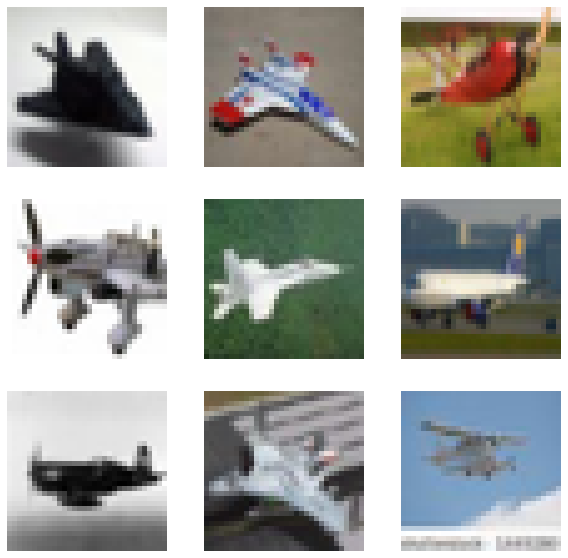

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_airplane[i])
  plt.axis("off")

In [7]:
def rgb_2_gray(image):
	if len(image.shape)==3:
		gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
	else:
		gray_image = np.array([cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in image])
	return gray_image


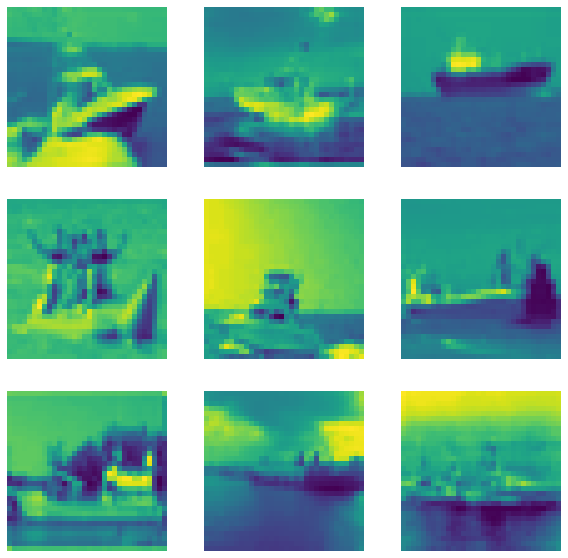

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(rgb_2_gray(X_train_ship[i]))
  plt.axis("off")

In [9]:
X_train_airplane_gray = rgb_2_gray(X_train_airplane).astype('float32') / 255.
X_train_ship_gray = rgb_2_gray(X_train_ship).astype('float32') / 255.

X_train_airplane = X_train_airplane.astype('float32') / 255.
X_train_ship = X_train_ship.astype('float32') / 255.


In [10]:
X_test_airplane_gray = rgb_2_gray(X_test_airplane).astype('float32') / 255.
X_test_ship_gray = rgb_2_gray(X_test_ship).astype('float32') / 255.

X_test_airplane = X_test_airplane.astype('float32') / 255.
X_test_ship = X_test_ship.astype('float32') / 255.


In [11]:
input_shape = (32, 32, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

In [12]:
inputs = Input(shape = input_shape)
x = inputs
for filters in layer_filters:
    x = Conv2D(filters = filters,
            kernel_size = kernel_size,
            strides = 2,
            activation ='relu',
            padding ='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name ='latent_vector')(x)
encoder = Model(inputs, latent, name ='encoder')


In [13]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-
# Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        activation ='relu',
                        padding ='same')(x)

outputs = Conv2DTranspose(filters = 3,
						kernel_size = kernel_size,
						activation ='sigmoid',
						padding ='same',
						name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')


In [14]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
					name ='autoencoder')

In [15]:
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder.fit(X_train_ship_gray,
				X_train_ship,
				validation_data =(X_test_ship_gray, X_test_ship),
				epochs = 30,
				batch_size = batch_size)

Epoch 1/30
157/157 [==============================] - 14s 87ms/step - loss: 0.0309 - val_loss: 0.0180
Epoch 2/30
157/157 [==============================] - 14s 87ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 3/30
157/157 [==============================] - 14s 87ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 4/30
157/157 [==============================] - 14s 91ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 5/30
157/157 [==============================] - 15s 94ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/30
157/157 [==============================] - 13s 86ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 7/30
157/157 [==============================] - 14s 87ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 8/30
157/157 [==============================] - 14s 87ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 9/30
157/157 [==============================] - 15s 96ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 10/30
157/157 [==============================] - 15s 95ms/step - loss: 0.008

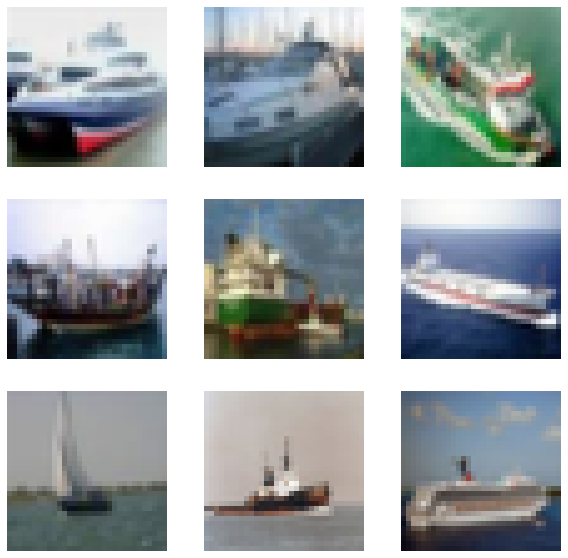

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test_ship[i])
  plt.axis("off")

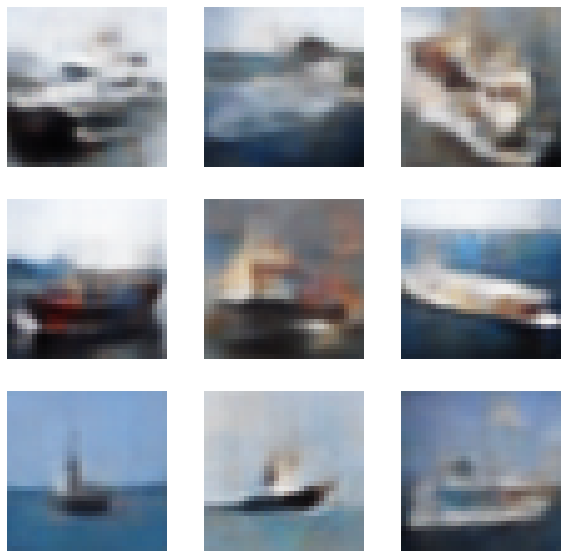

In [18]:
predictions = autoencoder.predict(X_test_ship_gray)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(predictions[i])
  plt.axis("off")